In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal, Bernoulli
np.random.seed(0)
torch.manual_seed(0)
opt= {}
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    opt['device']= torch.device('cuda:0')
    opt['if_cuda']=True
else:
    opt['device']= torch.device('cpu')
    opt['if_cuda']=False

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.])
tensor([[-1.0360,  0.9594],
        [-0.9863,  0.9555],
        [-1.0579,  0.9844],
        [-1.0079,  1.1128],
        [-1.0352,  1.0472],
        [-0.9626,  0.9406],
        [-0.9613,  0.9408],
        [-1.1330,  1.0303],
        [-1.0878,  1.0225],
        [-1.0342,  1.0830],
        [-0.9466,  0.9773],
        [-1.0344,  0.9393],
        [-1.0220,  0.9860],
        [-1.0182,  1.0078],
        [-0.9711,  1.0175],
        [-1.0382,  0.9281],
        [-0.9318,  0.9655],
        [-1.0326,  0.9739],
        [-1.0922,  0.9761],
        [-1.0240,  1.0310],
        [ 1.0349,  1.0002],
        [ 1.0466,  1.0170],
        [ 0.9992,  1.0080],
        [ 0.9905,  0.9803],
        [ 0.9866,  0.9436],
        [ 1.0140,  0.9503],
        [ 1.0421,  0.9875],
        [ 1

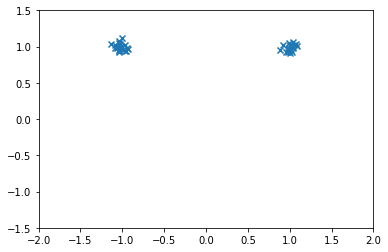

In [243]:
data_1=np.random.normal([-1,1],0.05,size=[20,2])
data_2=np.random.normal([1,1],0.05,size=[20,2])
label=[0]*20
label.extend([1]*20)
label1=[0]*20
label1_tensor=torch.tensor(np.asarray(label1),dtype=torch.float32).view(20,1)
label_tensor=torch.tensor(np.asarray(label),dtype=torch.float32)
print(label_tensor)
data=np.concatenate((data_1,data_2),axis=0)
data_tensor=torch.tensor(data, dtype=torch.float)
data1_tensor=data_tensor[0:20]
data2_tensor=data_tensor[20:]
label2=[1]*20
label2_tensor=torch.tensor(np.asarray(label2),dtype=torch.float32).view(20,1)
print(data_tensor)
data_numpy=data_tensor.numpy()
plt.scatter(data_numpy[:,0], data_numpy[:,1], marker="x")
plt.xlim([-2.0,2.0])
plt.ylim([-1.5,1.5])
plt.show()

In [244]:
# print(torch.randn(1))

torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)

u=(torch.randn(1)*0.1)
v=(torch.randn(1)*0.1)
c=(torch.randn(1)*0.1)
q=torch.exp(c)*torch.tensor([[torch.sqrt(1+u**2+v**2)+u, v], [v, torch.sqrt(1+u**2+v**2)-u]], requires_grad=True)
print(q)
a=torch.sigmoid((torch.randn(3,2)*0.1)).requires_grad_()
b=torch.sigmoid((torch.randn(2)*0.1)).requires_grad_()
print(a)
print(b)
print(a*b)

tensor([[ 1.1089,  0.0022],
        [ 0.0022,  1.0239]])
tensor([[ 0.4868,  0.4967],
        [ 0.4834,  0.5046],
        [ 0.4825,  0.5097]])
tensor([ 0.4973,  0.4819])
tensor([[ 0.2421,  0.2394],
        [ 0.2404,  0.2431],
        [ 0.2399,  0.2456]])


In [245]:
class Net(nn.Module):
    def __init__(self,learning_rate=1e-3):
        super(Net, self).__init__()
        self.device=opt['device']
        self.if_cuda=opt['if_cuda']

#         self.c=(torch.randn(1)*0.1).requires_grad_()
#         self.u=(torch.randn(1)*0.1).requires_grad_()
#         self.v=(torch.randn(1)*0.1).requires_grad_()
        self.std_diag=torch.sigmoid((torch.randn(2)*0.1)).requires_grad_()
#         self.q_cov=torch.exp(self.c)*torch.tensor([[torch.sqrt(1+self.u**2+self.v**2)+self.u, self.v], [self.v, torch.sqrt(1+self.u**2+self.v**2)-self.u]], requires_grad=True)
        self.q_mu=(torch.randn(2)).requires_grad_()
#         self.q_dis=MultivariateNormal(self.q_mu, covariance_matrix=self.q_cov)
        self.prior_mu=torch.tensor(np.zeros(2), dtype=torch.float, requires_grad=False)
#         self.prior_cov=torch.tensor([[1.0, 0.0], [0.0, 1.0]], requires_grad=False)
        self.prior_diag_cov=torch.tensor([0.5, 0.5], requires_grad=False)
        
        
#         params = [self.c,self.u,self.v,self.q_mu]
        params = [self.std_diag,self.q_mu]
        self.optimizer = optim.Adam(params, lr=learning_rate)

    
    def sample_from_posterior(self,sample_size):
        with torch.no_grad():
            eps=torch.randn(sample_size,2)
            samples=self.q_mu+eps*self.std_diag
            return samples
    
    
    
    
    def predict(self,x,sample_size):
        with torch.no_grad():
            eps=torch.randn(sample_size,2).to(self.device)
            weight_samples= (self.q_mu.to(self.device)+eps*self.std_diag.to(self.device)).view(sample_size,2,1).permute(0, 2, 1)
#             weight_samples=self.q_mu.view(1,2,1).permute(0, 2, 1).to(self.device)
            prediction=torch.mean(torch.sigmoid((weight_samples@x.t()).permute(2, 0, 1)),1)
            return prediction
#             return torch.sigmoid(x@self.q_mu.to(self.device))
        
    
    def train(self,x,label,sample_size):
        train_losses = []
        for epoch in range(0,3000):
            self.optimizer.zero_grad()
            eps=torch.randn(sample_size,2).to(self.device)
            weight_samples= (self.q_mu.to(self.device)+eps*self.std_diag.to(self.device)).view(sample_size,2,1).permute(0, 2, 1)
            output = torch.mean(torch.mean(torch.sigmoid((weight_samples@x.t()).permute(2, 0, 1)),1),1)
            nll_loss= torch.sum(-Bernoulli(probs=output).log_prob(label))
            kl=KL_diag_gaussian(self.q_mu.to(self.device),(self.std_diag**2).to(self.device),self.prior_mu.to(self.device),self.prior_diag_cov.to(self.device))
            neg_elbo=nll_loss+kl
            neg_elbo.backward()
            self.optimizer.step()
            train_losses.append(neg_elbo.item())
        plt.plot(train_losses)
        plt.show()
        return train_losses
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

torch.Size([20, 2])
torch.Size([20, 1])


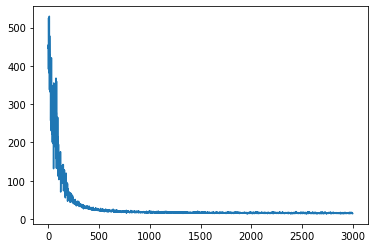

In [249]:
active_bnn = Net(1e-2).to(opt['device'])
print(data1_tensor.size())
print(label1_tensor.size())
nelbo_1=active_bnn.train(data1_tensor.to(opt['device']),label1_tensor.to(opt['device']),10)

In [250]:
prediction=active_bnn.predict(data1_tensor.to(opt['device']),100)
print(active_bnn.q_mu)
print(prediction.cpu().numpy())

tensor([ 2.5114, -2.0755])
[[0.01099961]
 [0.01247262]
 [0.0099542 ]
 [0.00878081]
 [0.0093196 ]
 [0.01357507]
 [0.01361068]
 [0.0076288 ]
 [0.00861926]
 [0.00872736]
 [0.01314978]
 [0.01147284]
 [0.01080637]
 [0.01045968]
 [0.01149082]
 [0.01161531]
 [0.01393177]
 [0.01078314]
 [0.00932223]
 [0.00987163]]


(1000, 2)


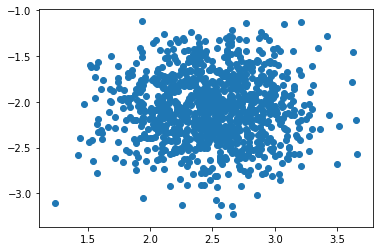

In [251]:
yo=active_bnn.sample_from_posterior(1000).detach().numpy()
print(np.shape(yo))
plt.scatter(yo[:, 0], yo[:, 1])
plt.show()

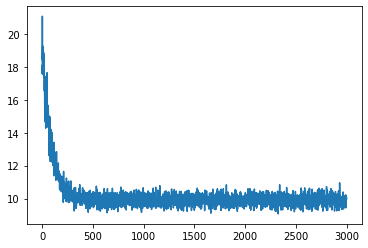

In [252]:
active_bnn_true = Net(learning_rate=5e-3).to(opt['device'])
nelbo_1=active_bnn_true.train(data_tensor.to(opt['device']),label_tensor.to(opt['device']),50)
# nelbo_1=active_bnn_true.train(data2_tensor.to(opt['device']),label2_tensor.to(opt['device']),1)

In [253]:
print(active_bnn_true.q_mu)

tensor([ 2.1862,  0.0033])


In [254]:
prediction=active_bnn_true.predict(data_tensor.to(opt['device']),100)
print(prediction)

tensor([[ 0.1109],
        [ 0.1209],
        [ 0.1071],
        [ 0.1198],
        [ 0.1128],
        [ 0.1257],
        [ 0.1260],
        [ 0.0946],
        [ 0.1023],
        [ 0.1138],
        [ 0.1301],
        [ 0.1108],
        [ 0.1142],
        [ 0.1154],
        [ 0.1255],
        [ 0.1098],
        [ 0.1332],
        [ 0.1118],
        [ 0.1007],
        [ 0.1147],
        [ 0.9060],
        [ 0.9079],
        [ 0.8995],
        [ 0.8980],
        [ 0.8973],
        [ 0.9024],
        [ 0.9072],
        [ 0.9001],
        [ 0.9056],
        [ 0.8977],
        [ 0.8827],
        [ 0.8768],
        [ 0.9002],
        [ 0.8903],
        [ 0.9139],
        [ 0.9048],
        [ 0.8965],
        [ 0.8970],
        [ 0.9072],
        [ 0.9123]], device='cuda:0')


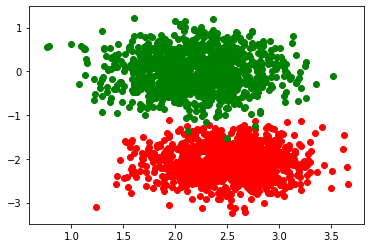

In [255]:
yo_true=active_bnn_true.sample_from_posterior(1000).detach().numpy()

plt.scatter(yo[:, 0], yo[:, 1],c='red')
plt.scatter(yo_true[:, 0], yo_true[:, 1],c='green')
plt.show()

In [ ]:
for i in range(0,10):
    x_new=train_dict[8][21].view(-1,1,28,28)
    label_new=torch.tensor([8])
    active_bnn_1.online_train(x_new,label_new)
    print('entropy',active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
    likelihood_of_initial_dataset,accuracy=active_bnn_1.likelihood_eva(initial_train_data_tensor,initial_train_label_tensor)
    print('lieklihood',likelihood_of_initial_dataset)
    print('accuracy',accuracy)

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])
active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_1 = Net(feature_dim=50,q_rank=100)
nelbo_1=active_bnn_1.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[1][20].view(-1,1,28,28)
label_new=torch.tensor([1])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
x_new=train_dict[4][16].view(-1,1,28,28)
label_new=torch.tensor([4])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_2.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][22].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_2.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_2 = Net(q_rank=2)
nelbo_2=active_bnn_2.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_2.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_3 = Net(q_rank=3)
nelbo_3=active_bnn_3.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
active_bnn_10 = Net(q_rank=10)
nelbo_10=active_bnn_10.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_10.online_train(x_new,label_new)

In [ ]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_10.online_train(x_new,label_new)

In [ ]:
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][22]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[8][23]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_10.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
active_bnn_50 = Net(q_rank=50)
nelbo_50=active_bnn_50.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [ ]:
plt.plot(nelbo_50,label='50')
plt.plot(nelbo_10,label='10')
plt.plot(nelbo_3,label='3')
plt.plot(nelbo_2,label='2')
plt.plot(nelbo_1,label='1')

plt.legend()
plt.show()

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
cccccccccccccccccccc

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn_1.online_train(x_new,label_new)

In [ ]:
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn_1.predictive_distribution_entropy_2(train_dict[4][15]))

In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))

In [ ]:
for i in range(0,30):
    x_new=train_dict[8][i].view(-1,1,28,28)
    label_new=torch.tensor([8])

    active_bnn.online_train(x_new,label_new)

In [ ]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))